In [30]:

import os
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from PIL import Image

import tensorflow as tf


In [3]:
BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

this_folder = os.path.abspath("")
DATA_FOLDER = os.path.join(this_folder, "data", "scenario1", "split")
MODELS_FOLDER = os.path.join(this_folder, "models")
os.listdir(DATA_FOLDER)

['val', 'train', 'test']

In [4]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

2021-10-20 16:28:35.564424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-20 16:28:35.564453: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-20 16:28:35.564468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frcaud-Latitude-7420): /proc/driver/nvidia/version does not exist
2021-10-20 16:28:35.564746: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'train'),
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)
class_names = train_dataset.class_names
print(class_names)

Found 569 files belonging to 5 classes.
['0_Negative', '1_Primordial', '2_Primary', '3_Secondary', '4_Tertiary']


In [11]:
pathlib.Path(DATA_FOLDER)

PosixPath('/home/frcaud/frcaud/follicles_detection/data/scenario1/split')

In [29]:
image_count = len(list(pathlib.Path(DATA_FOLDER).glob('*/*/*.jpg')))
print(f'Total images count : {image_count}')

Total images count : 767


In [17]:
DIR_NAMES = ["0_Negative", "1_Primordial", "2_Primary", "3_Secondary", "4_Tertiary"]

In [37]:
image_count_by_class = [len(list(pathlib.Path(DATA_FOLDER).glob(os.path.join('*', dir_name, '*.jpg')))) for dir_name in DIR_NAMES]
pd.DataFrame(image_count_by_class, index=DIR_NAMES)

,0
0_Negative,366
1_Primordial,135
2_Primary,89
3_Secondary,118
4_Tertiary,59


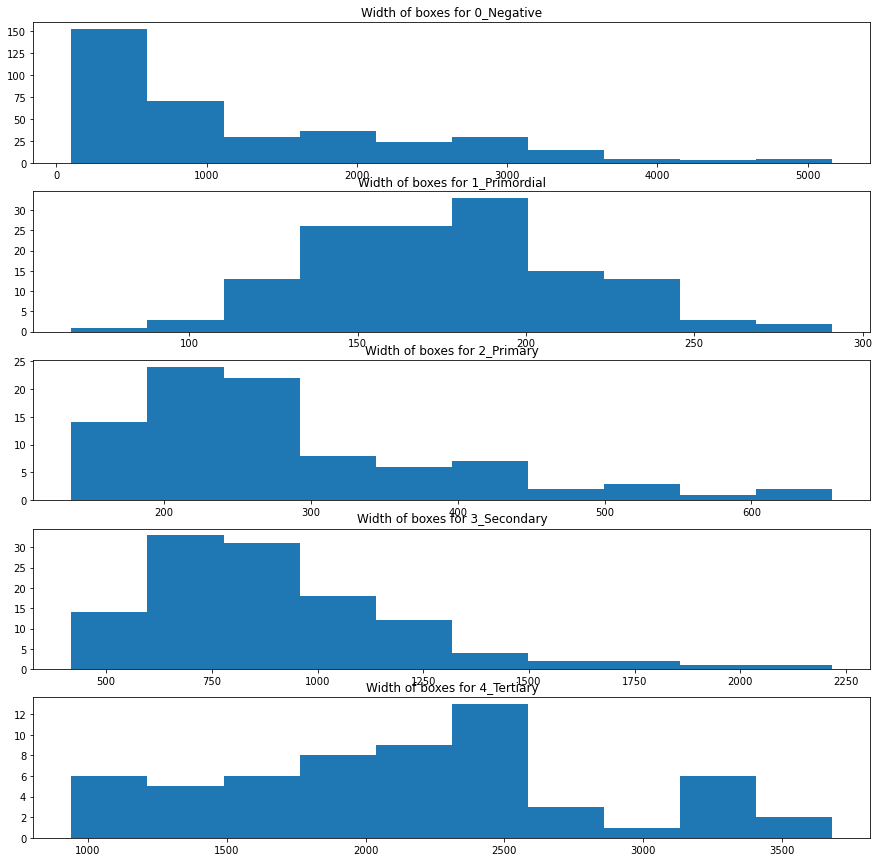

In [71]:
plt.figure(figsize=(15,15))
for i, dir_name in enumerate(DIR_NAMES):
    list_dir_name = list(pathlib.Path(DATA_FOLDER).glob(os.path.join('*', dir_name, '*.jpg')))
    width_list_dir_name = [Image.open(name).width for name in list_dir_name]
    ax = plt.subplot(5, 1, i+1)
    plt.hist(width_list_dir_name)
    plt.title(f'Width of boxes for {dir_name}')

In [5]:
test_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'test'),
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 78 files belonging to 5 classes.


In [6]:
val_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'val'),
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 120 files belonging to 5 classes.


In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2021-10-19 17:18:58.078173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(10, 7, 7, 1280)


In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 5)


In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

In [16]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset)

Epoch 1/30
57/57 [==============================] - 10s 134ms/step - loss: 1.5881 - sparse_categorical_accuracy: 0.3585 - val_loss: 1.3327 - val_sparse_categorical_accuracy: 0.4417
Epoch 2/30
57/57 [==============================] - 7s 121ms/step - loss: 1.2309 - sparse_categorical_accuracy: 0.5009 - val_loss: 1.1200 - val_sparse_categorical_accuracy: 0.4917
Epoch 3/30
57/57 [==============================] - 10s 161ms/step - loss: 1.0376 - sparse_categorical_accuracy: 0.5764 - val_loss: 0.9779 - val_sparse_categorical_accuracy: 0.5833
Epoch 4/30
57/57 [==============================] - 11s 185ms/step - loss: 0.8905 - sparse_categorical_accuracy: 0.6309 - val_loss: 0.8775 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/30
57/57 [==============================] - 9s 153ms/step - loss: 0.8269 - sparse_categorical_accuracy: 0.6766 - val_loss: 0.8050 - val_sparse_categorical_accuracy: 0.6833
Epoch 6/30
57/57 [==============================] - 9s 142ms/step - loss: 0.7393 - sparse_categor

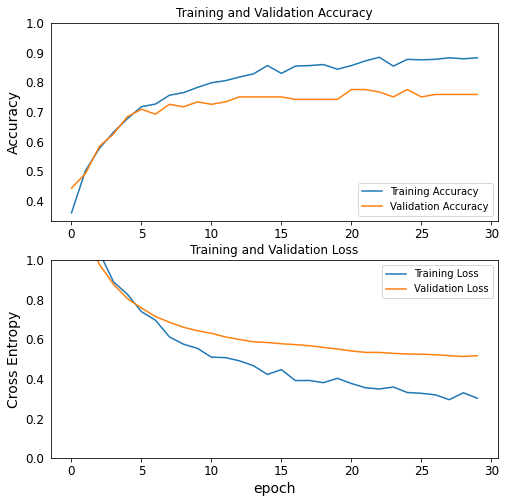

In [17]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = True
plt.rcParams['ytick.labelsize'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [8, 8]
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 91ms/step - loss: 0.4047 - sparse_categorical_accuracy: 0.8718
Test accuracy : 0.8717948794364929


In [19]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=1)
print('predictions:', predictions)
print('truth:      ', label_batch)

predictions: [2 0 1 3 2 0 2 1 2 0]
truth:       [2 0 1 3 2 0 2 1 2 0]


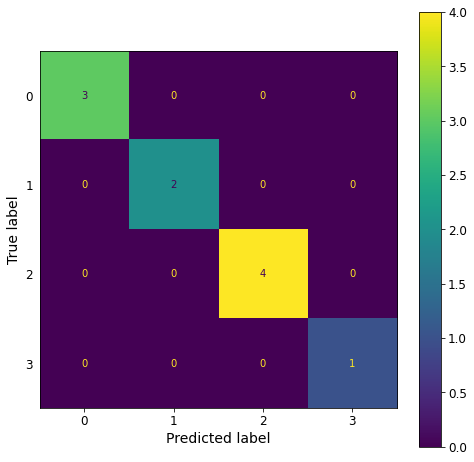

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(label_batch, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

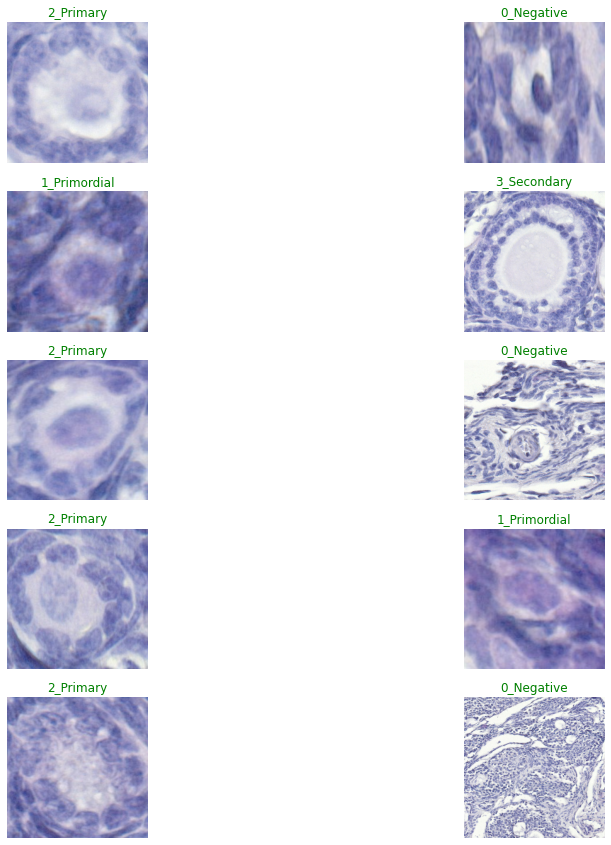

In [21]:
plt.figure(figsize=(15, 15))
for i in range(10):
  ax = plt.subplot(5, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  if predictions[i] != label_batch[i]:
    color = 'red'
  else:
    color = 'green'
  plt.title(class_names[predictions[i]], color=color)
  plt.axis("off")

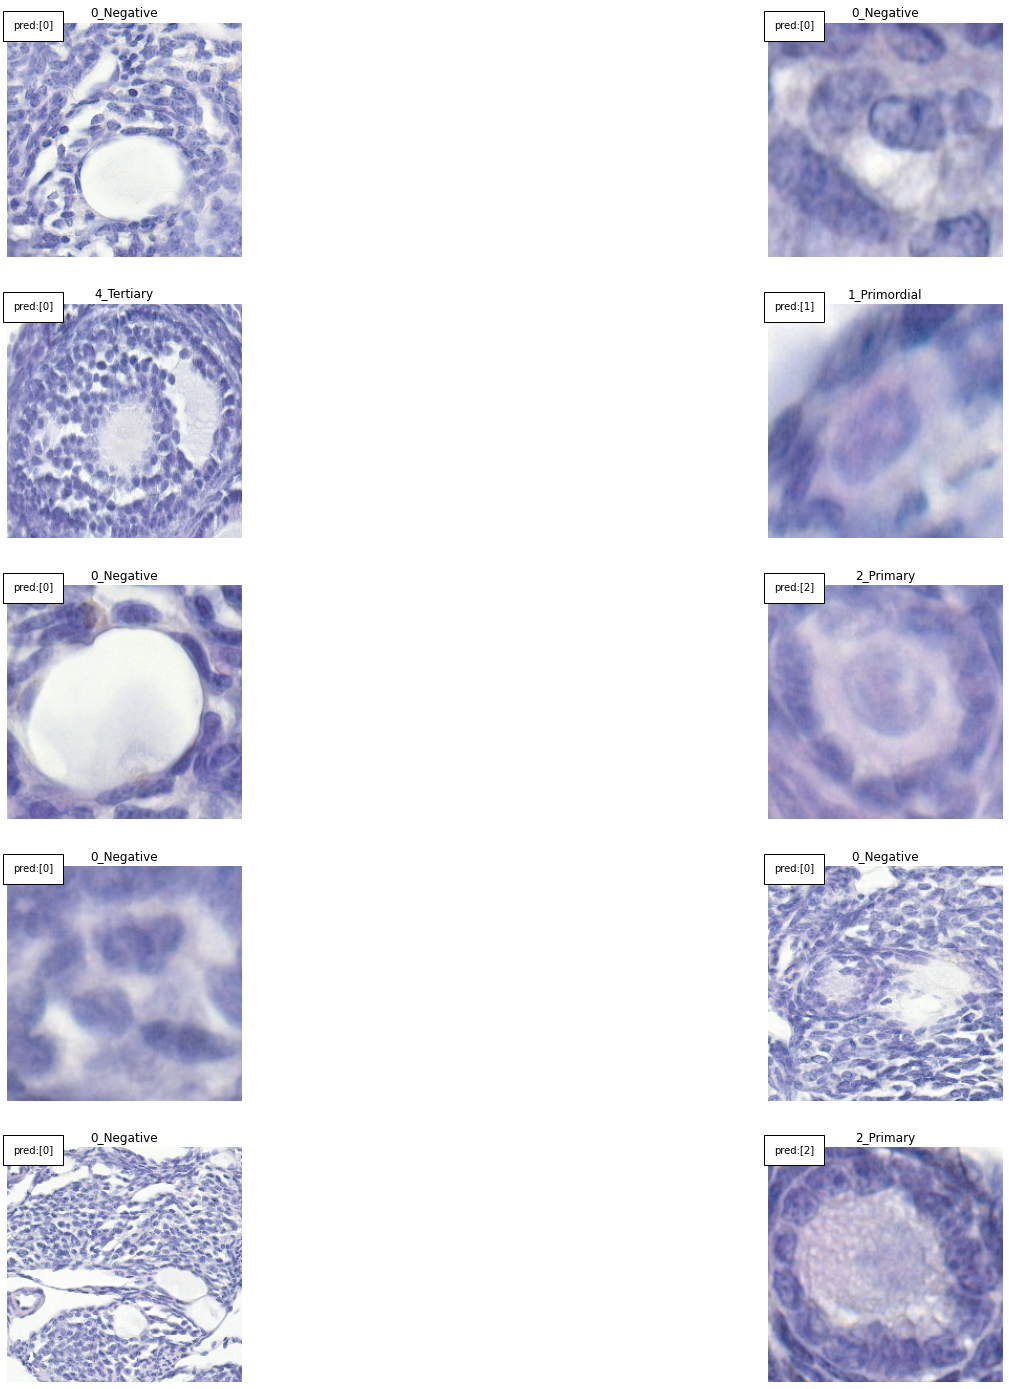

In [22]:
for images, labels in test_dataset.take(1):
    plt.figure(figsize=(25,25))
    for i in range(10):
        ax = plt.subplot(5, 2, i+1)
        ax.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        pred = model.predict(tf.reshape(images[i], (1, 224, 224, 3)))
        pred = np.argmax(pred, axis=1)
        ax.text(5,5,f'pred:{pred}', bbox={'facecolor': 'white', 'pad': 10})
        plt.axis("off")

In [23]:
model.save(os.path.join(MODELS_FOLDER, "classifier"))

2021-10-19 17:24:47.649250: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/frcaud/frcaud/follicles_detection/models/classifier/assets


/home/frcaud/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, "classifier"))
model_loaded

In [25]:
def predict_image(image, model):
    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224,3))
    pred = model.predict(image)
    return np.argmax(pred), np.max(pred)


In [26]:
im = Image.open("test/3_Secondary/D-1M03-6.tiff-Secondary-x.min7795-y.min8560-x.max8721-y.max9447.jpg")
predict_image(im, model_loaded)

(3, 0.804626)

In [ ]:
coupe = Image.open('data/D-1M01-2.jpg')
plt.imshow(coupe)

(3, 0.9703898)

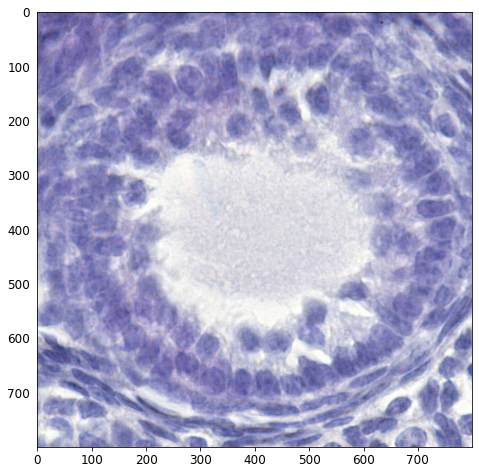

In [29]:
im1 = coupe.crop((1000,500,1800,1300))
plt.imshow(im1)
predict_image(im1, model_loaded)

(0, 0.96104157)

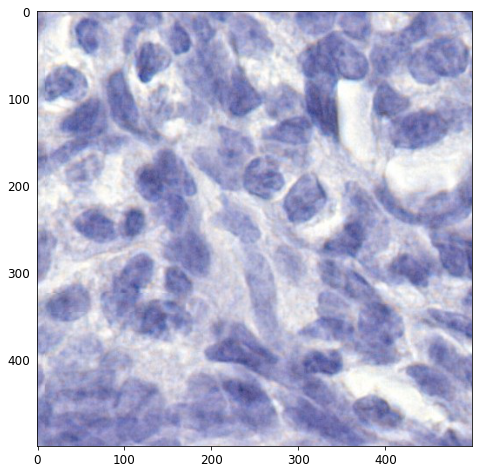

In [30]:
im2 = coupe.crop((2000,2000,2500,2500))
plt.imshow(im2)
predict_image(im2, model_loaded)

(2, 0.7913315)

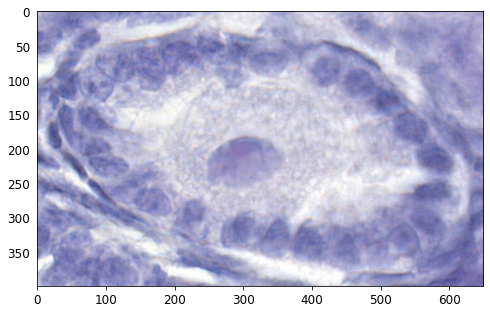

In [31]:
im3 = coupe.crop((3000,2350,3650,2750))
plt.imshow(im3)
predict_image(im3, model_loaded)

(0, 0.72755796)

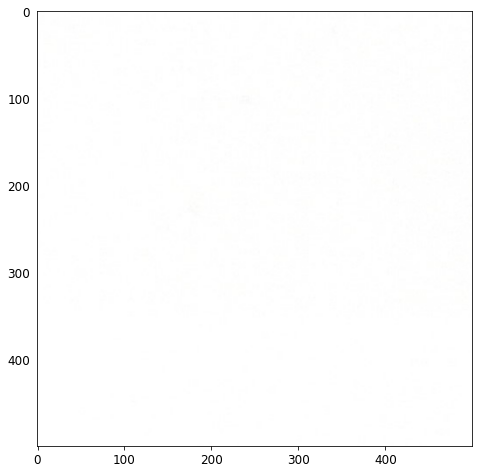

In [32]:
im4 = coupe.crop((0,0,500,500))
plt.imshow(im4)
predict_image(im4, model_loaded)

# Predict on the whole test dataset

In [38]:
test_dataset_nobatch = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'test'),
    batch_size=78,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 78 files belonging to 5 classes.


In [122]:
preds = []
labels = []
for image, label in test_dataset_nobatch.as_numpy_iterator():
    pred = model.predict(image)
    pred = np.argmax(pred, axis=1)
    preds.append(pred)
    labels.append(label)
print(preds)
print(labels)

[array([2, 1, 3, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 2, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 3, 4, 0, 0, 0, 0, 0, 3, 2, 3, 1, 2, 0, 2, 2,
       0, 0, 4, 0, 2, 0, 3, 4, 0, 1, 4, 0, 3, 2, 0, 0, 4, 0, 1, 1, 0, 1,
       3, 1, 1, 0, 0, 1, 0, 0, 2, 4, 3, 0])]
[array([3, 0, 3, 1, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0, 0, 2, 4, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0, 3, 2, 3, 1, 2, 0, 3, 2,
       0, 0, 4, 0, 2, 0, 3, 0, 0, 1, 4, 0, 3, 2, 0, 0, 4, 0, 1, 1, 0, 1,
       3, 0, 1, 4, 0, 1, 0, 0, 2, 4, 3, 0], dtype=int32)]


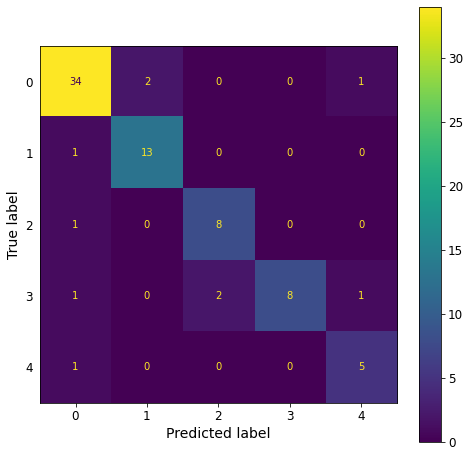

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(labels[0], preds[0])
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

In [124]:
from sklearn.metrics import classification_report

print(classification_report(labels[0], preds[0], target_names=["Negative", "Primordial", "Primary", "Secondary", "Tertiary"]))

              precision    recall  f1-score   support

    Negative       0.89      0.92      0.91        37
  Primordial       0.87      0.93      0.90        14
     Primary       0.80      0.89      0.84         9
   Secondary       1.00      0.67      0.80        12
    Tertiary       0.71      0.83      0.77         6

    accuracy                           0.87        78
   macro avg       0.86      0.85      0.84        78
weighted avg       0.88      0.87      0.87        78



In [108]:
predicts = model_loaded.predict(test_dataset)
predicts = np.argmax(predicts, axis=1)
predicts

array([0, 1, 3, 2, 0, 2, 4, 0, 3, 0, 0, 0, 1, 2, 0, 2, 0, 4, 1, 1, 0, 0,
       3, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 4, 1, 3, 4, 1, 0, 0, 1, 0, 4,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 1, 4, 3, 0, 0, 0, 1, 1, 1, 2,
       1, 0, 0, 3, 2, 0, 2, 3, 1, 0, 1, 4])

In [120]:
for image, label in test_dataset.unbatch():
    print(type(image))
    print(type(label))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.fr

In [109]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y

array([0, 3, 1, 3, 0, 4, 1, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0,
       0, 2, 1, 0, 3, 3, 3, 1, 2, 0, 0, 1, 3, 0, 0, 2, 0, 0, 0, 2, 3, 4,
       0, 0, 4, 0, 0, 0, 3, 4, 1, 1, 0, 3, 1, 1, 2, 3, 2, 0, 0, 0, 1, 1,
       2, 0, 0, 4, 0, 4, 0, 0, 3, 0, 2, 1], dtype=int32)

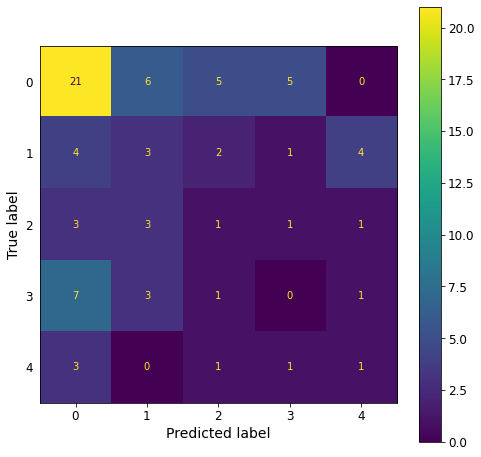

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(y, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

In [111]:
from sklearn.metrics import classification_report

print(classification_report(y, predicts, target_names=["Negative", "Primordial", "Primary", "Secondary", "Tertiary"]))

              precision    recall  f1-score   support

    Negative       0.55      0.57      0.56        37
  Primordial       0.20      0.21      0.21        14
     Primary       0.10      0.11      0.11         9
   Secondary       0.00      0.00      0.00        12
    Tertiary       0.14      0.17      0.15         6

    accuracy                           0.33        78
   macro avg       0.20      0.21      0.21        78
weighted avg       0.32      0.33      0.33        78



In [ ]:
numpy_images = []
numpy_labels = []
for images, labels in test_dataset.take(-1):
    numpy_images.append(images.numpy())
    numpy_labels.append(labels.numpy())

# Data augmentation

In [101]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    #tf.keras.layers.RandomZoom(0.1),
  ]
)


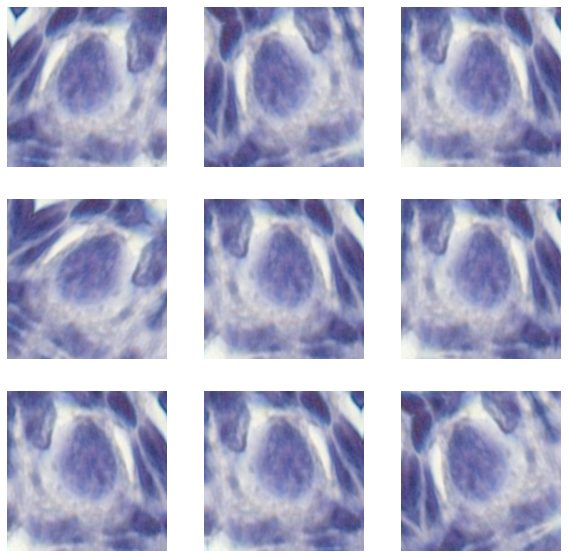

In [103]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")
